# Amazon Food Reviews NLP

This dataset contains raw text reviews of "fine food reviews" from Amazon over more than 10 years.
A product rating is provided as a value between 1 and 5.  This notebook will exploring training various algorithms to predict the rating of a review based on its review text.

## Approach

I'm thinking about three different approaches here.  The first approach is to predict a continous output between 1 and 5 (normalized to 0.2 => 1).  This approach intends for an algorithm to essentially learn review sentiment encoded as this output value. For this approach, I'll explore using neural networks, normalizing the target value and use a sigmoid output function.  I'll compare the results to other regression techniques.

An alternative approach would be to create a binary classifier that predicts discrete values of 0 or 1, considering reviews with 1 and 2 stars as "negative reviews" (0) and 4 or 5 stars as "positive reviews", discarding 3 stars, or randomly sampling 3 star reviews into both positive or negative classes.

A third approach would be to treat the problem as a classification problem, and build a discrete classifier that predicted each review was one of five classes.  This seems most unintuitive, but I suspect that it is worth exploring.  Here, I consider using a CNN to build a classifier with the output as a one-hot encoding of the rating.  Alternatively, I may consider building 5 binary classifiers to distinguish between classes.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re

import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set(style='dark', palette='muted', font_scale=1.1, rc={'figure.figsize': [16, 6]})

## Raw Data

### Amazon Fine Food Reviews Dataset

Download Amazon Fine Food Reviews Dataset

> https://www.kaggle.com/snap/amazon-fine-food-reviews

In [4]:
AMZ_FOOD_DIR = 'amz_data'
AMZ_FOOD_CSV = 'food_reviews.csv'
DATA_AMZ_FOOD = os.path.join(AMZ_FOOD_DIR, AMZ_FOOD_CSV)

In [5]:
df = pd.read_csv(DATA_AMZ_FOOD)

# get a subset of data to run as draft
# df = df[:10_000]

## Feature Inspection

In [6]:
df.shape

(568454, 10)

In [7]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


_Rename the columns to preference_

In [8]:
col_rename_map = {
    'ProductId': 'product_id',
    'HelpfulnessNumerator': 'helpful_count',
    'HelpfulnessDenominator': 'helpful_total',
    'Score': 'score',
    'Summary': 'summary_text',
    'Text': 'review_text',
    'Time': 'unix_epoch'
}

df.rename(columns=col_rename_map, inplace=True)
df.head(3)

,Id,product_id,UserId,ProfileName,helpful_count,helpful_total,score,unix_epoch,summary_text,review_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Id             568454 non-null  int64 
 1   product_id     568454 non-null  object
 2   UserId         568454 non-null  object
 3   ProfileName    568438 non-null  object
 4   helpful_count  568454 non-null  int64 
 5   helpful_total  568454 non-null  int64 
 6   score          568454 non-null  int64 
 7   unix_epoch     568454 non-null  int64 
 8   summary_text   568427 non-null  object
 9   review_text    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Target Data Inspection

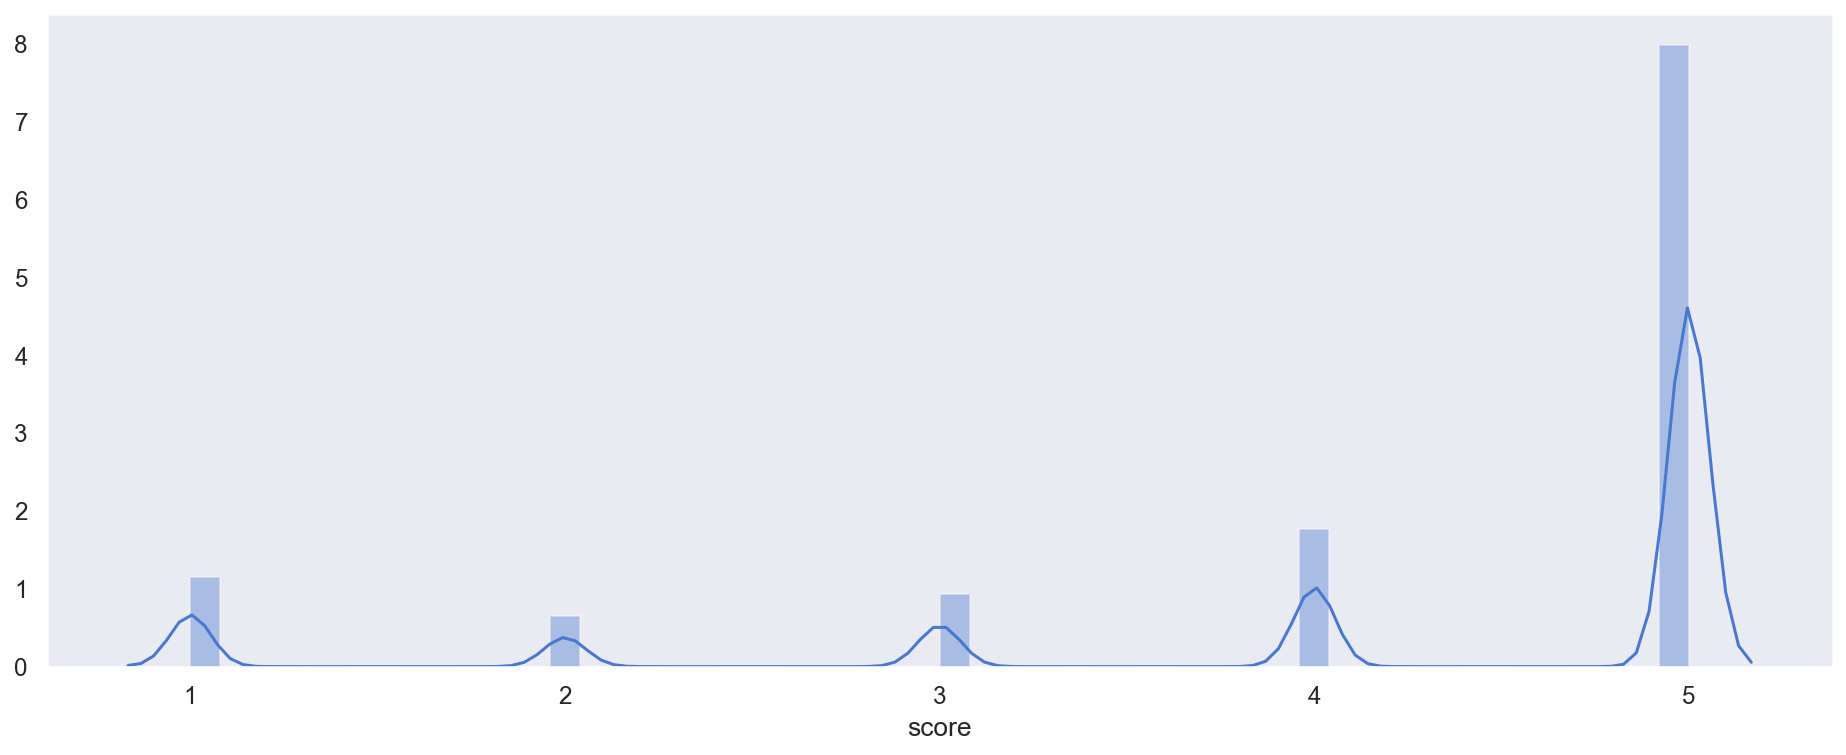

In [10]:
sns.distplot(df.score)

Inspecting the distribution of target values, it's clear that we have heavily imbalanced data.

### The Problem with Imbalanced Classes

Typically, we want balanced classes to train machine learning models. Many algorithms work to maximize accuracy. Think about accuracy as a metric - we could just predict the value of the review to be 5.0 and already achieve ~65% accuracy, much higher than random choice in this case.

### Approaches to rectifying

- undersample majority class
- oversample minority classes
- generate synthetic data

Since the size of the data is small, oversampling minority classes may be a good approach.  I will first explore generating synthetic data using `SMOTE`, or Synthetic Minority Oversampling Technique, which seems interesting.

Reference: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106

In [11]:
from imblearn.over_sampling import SMOTE

# Will apply resampling after cleaning data and segregating target and features

## Data Preprocessing

In [12]:
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

### Clean Features

- drop irrelevant
- drop duplicates
- convert unix epoch to timestamp
- encode categorical
- handle NaN values

In [13]:
df.drop(['Id', 'UserId', 'ProfileName'], axis=1, inplace=True)

In [14]:
# drop dupes
df = df.drop_duplicates(subset={"product_id","summary_text","unix_epoch","review_text"})
df.shape

(567616, 7)

In [15]:
# convert unix epoch to date type
df['timestamp'] = pd.to_datetime(df['unix_epoch'], unit='s')
df.drop(columns=['unix_epoch'], inplace=True)
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp
0,B001E4KFG0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,B00813GRG4,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,B000LQOCH0,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18


In [16]:
prod_id_enc = LabelEncoder()
df.product_id = prod_id_enc.fit_transform(df.product_id)
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp
0,27619,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,72383,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,15267,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18


In [17]:
df.isna().sum()

product_id        0
helpful_count     0
helpful_total     0
score             0
summary_text     27
review_text       0
timestamp         0
dtype: int64

Depending on the subsample from this data, there are no or very few rows containing missing data. 

Dropping these rather than imputing.

In [18]:
prev_rowcount = df.shape[0]
df.dropna(inplace=True)
new_rowcount = df.shape[0]
print(f'Dropped {new_rowcount - prev_rowcount} rows containing missing values')

Dropped -27 rows containing missing values


## Feature Engineering

Reduce dimensionality by combining `helpful_count` and `helpful_total`

In [19]:
df['helpful_ratio'] = df['helpful_count'] / df['helpful_total']
df.drop(['helpful_count', 'helpful_total'], axis=1)
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp,helpful_ratio
0,27619,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,1.0
1,72383,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,NaN
2,15267,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,1.0


Computing `helpful_ratio` caused many `NaN` values for data where `helpful_total` was `0`.

Replacing these with 0.

In [20]:
df.isna().sum()

product_id            0
helpful_count         0
helpful_total         0
score                 0
summary_text          0
review_text           0
timestamp             0
helpful_ratio    269787
dtype: int64

In [21]:
df.fillna(0, inplace=True)
df.isna().sum()

product_id       0
helpful_count    0
helpful_total    0
score            0
summary_text     0
review_text      0
timestamp        0
helpful_ratio    0
dtype: int64

## Basic text preprocessing

### Clean up Review and Summary text data

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

Create a function to clean up strings

Apply the function to `summary_text` and `review_text` columns

In [23]:
def clean_str(string):
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [24]:
df['summary_text'] = df['summary_text'].astype(str).apply(clean_str)
df['review_text'] = df['review_text'].astype(str).apply(clean_str)
df[['review_text', 'summary_text']].head(3)

,review_text,summary_text
0,i have bought several of the vitality canned d...,good quality dog food
1,product arrived labeled as jumbo salted peanut...,not as advertised
2,this is a confection that has been around a fe...,delight says it all


### Tokenize Text Data

Keras provides a builtin `Tokenizer` that can be used for the purpose of tokenizing raw clean strings

In [25]:
sents = df['review_text']

In [26]:
# Specify max vocab size
MAX_NB_WORDS = 20_000

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(sents)
sequences = tokenizer.texts_to_sequences(sents)

In [27]:
# peak at the sequences
np.asarray(sequences)[:1]

array([list([2, 17, 124, 318, 7, 1, 4918, 521, 103, 55, 200, 3, 17, 117, 28, 42, 5, 30, 7, 29, 184, 1, 39, 639, 48, 25, 4, 2628, 58, 4, 1175, 447, 3, 6, 616, 98, 13, 5235, 8, 1773, 3, 101, 8636, 9, 39, 98, 58, 140])],
      dtype=object)

In [28]:
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 122978 unique tokens.


In [29]:
# peak at the word index
word_index['good']

29

### Determine a Maximum Sequence Length

The reviews are naturally different lengths.  However, it would be ideal for downstream neural network models to accept tensors of the same size.  We can choose a maximum sequence length and pad sequences using Keras.

To choose the maximum length, I'll look at the distribution of length of reviews.

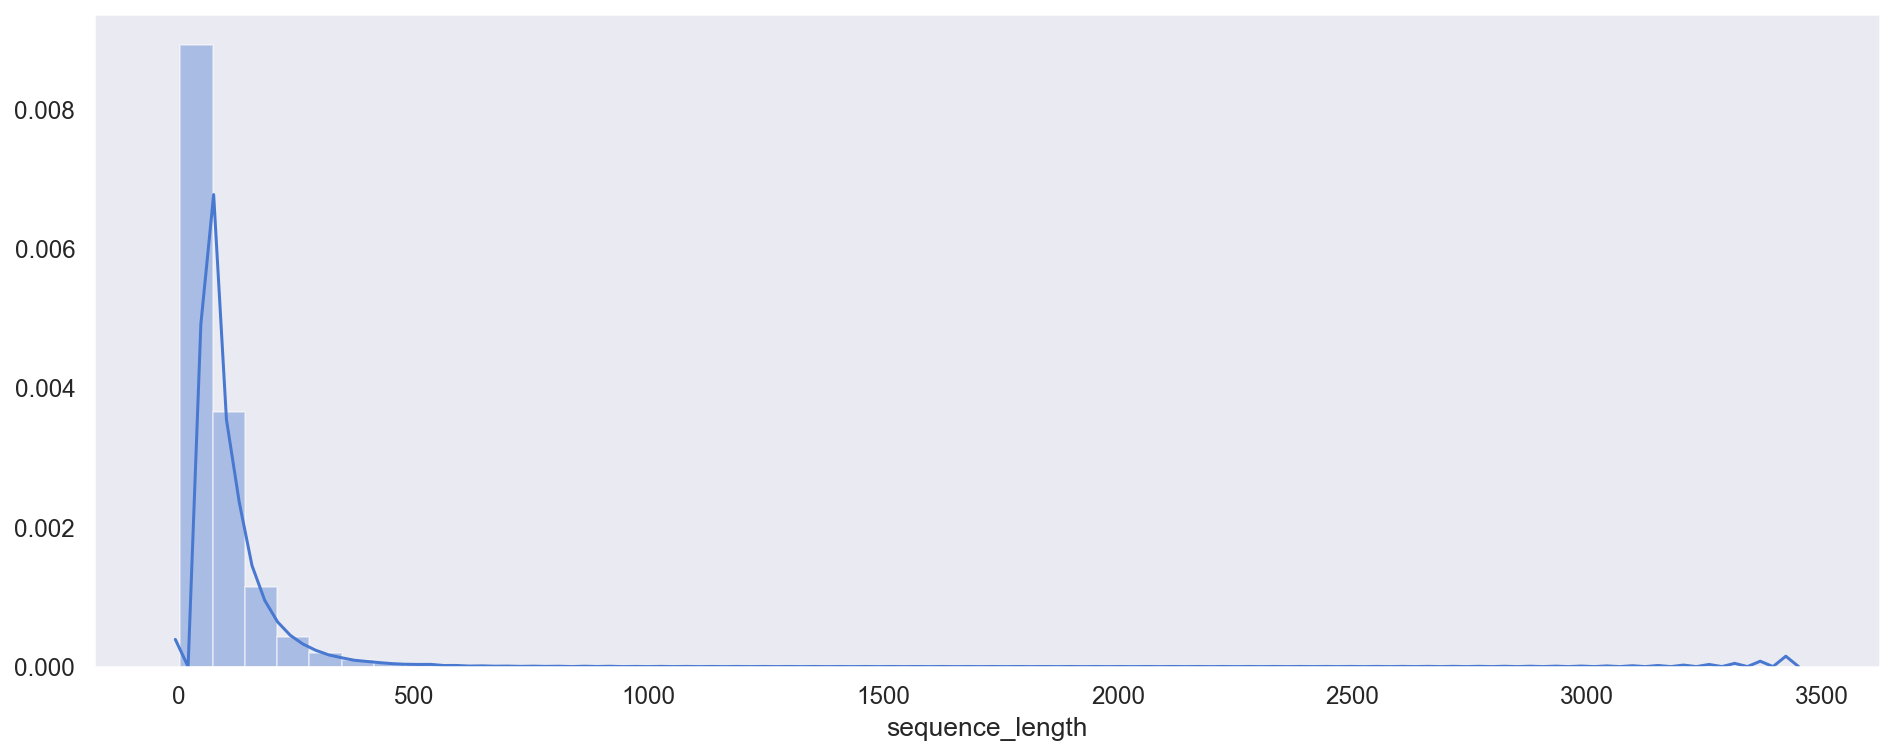

In [30]:
df['sequences'] = sequences
df['sequence_length'] = df['sequences'].apply(len)

sns.distplot(df.sequence_length)

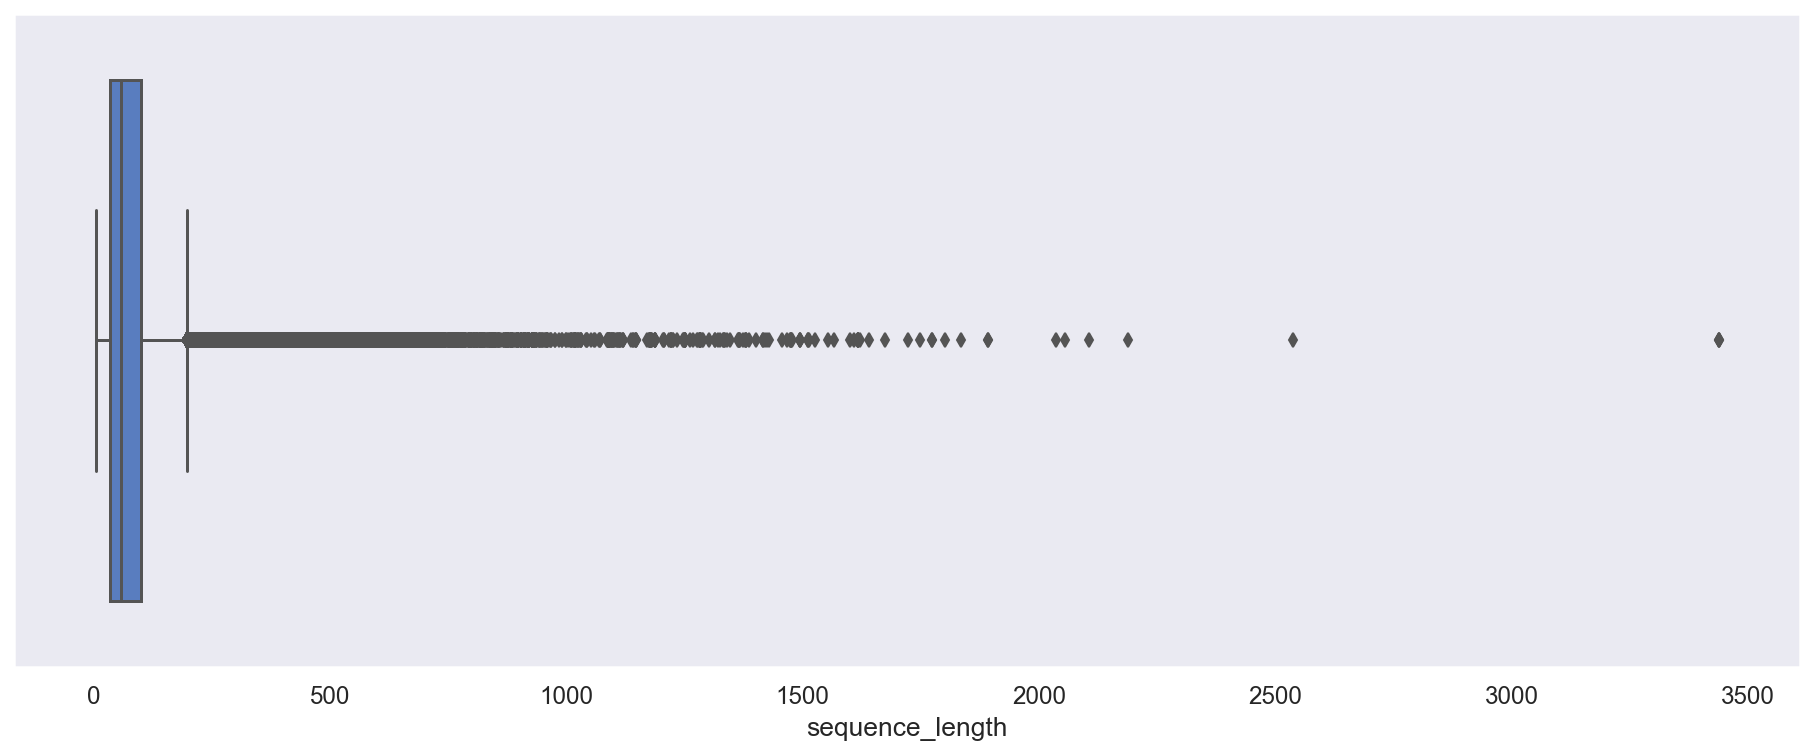

In [31]:
sns.boxplot(df.sequence_length)

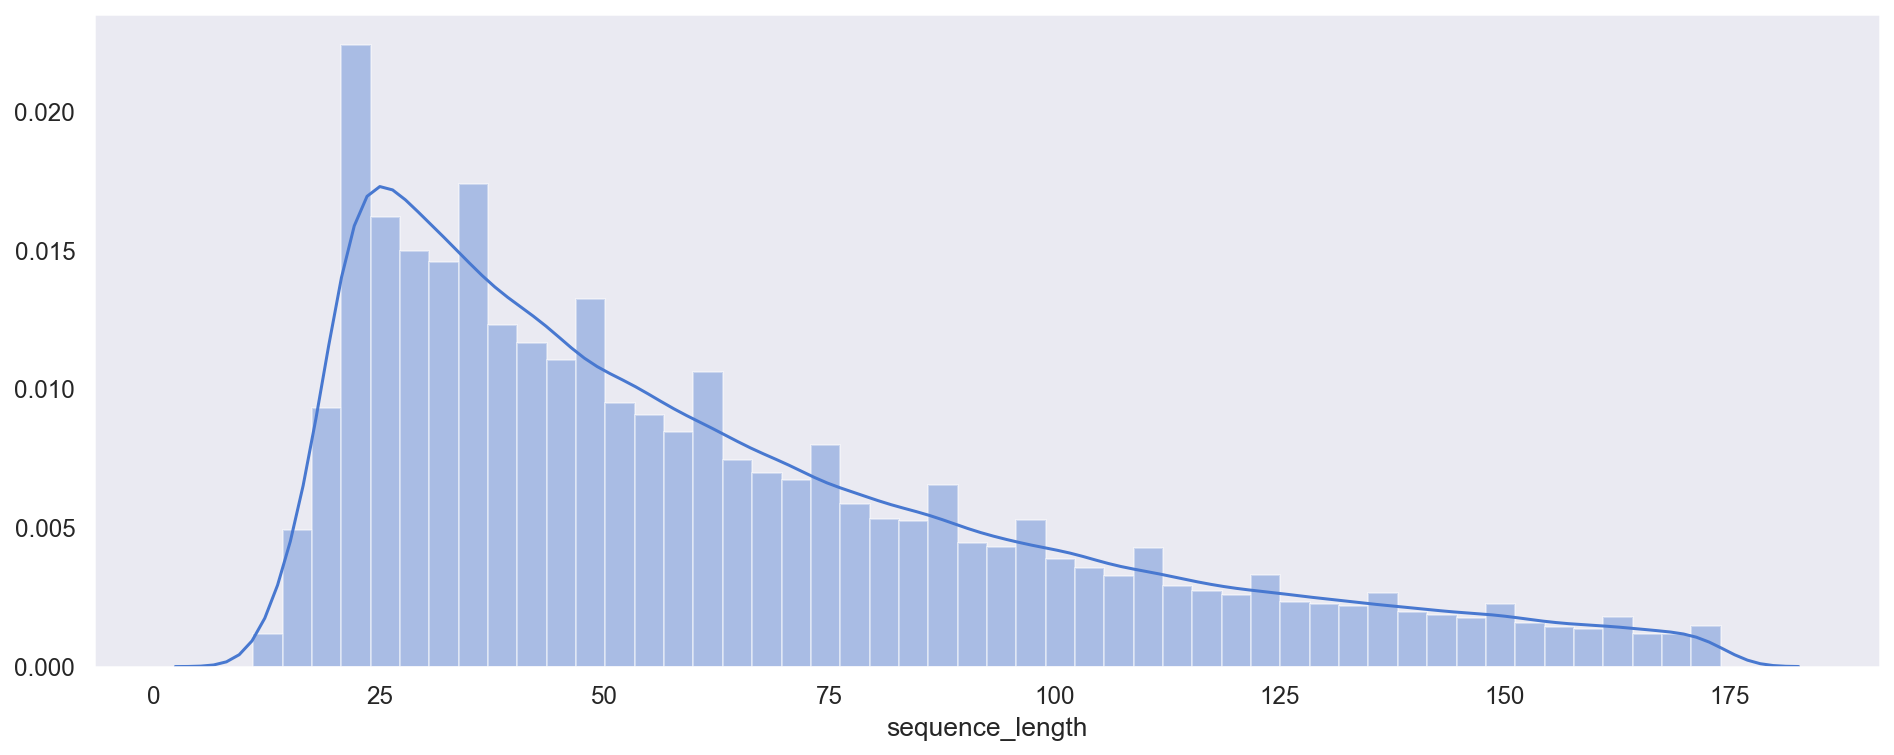

In [32]:
# Look at the distribution of length where length between 10 and 175
sns.distplot(df[(df.sequence_length < 175) & (df.sequence_length > 10)].sequence_length)

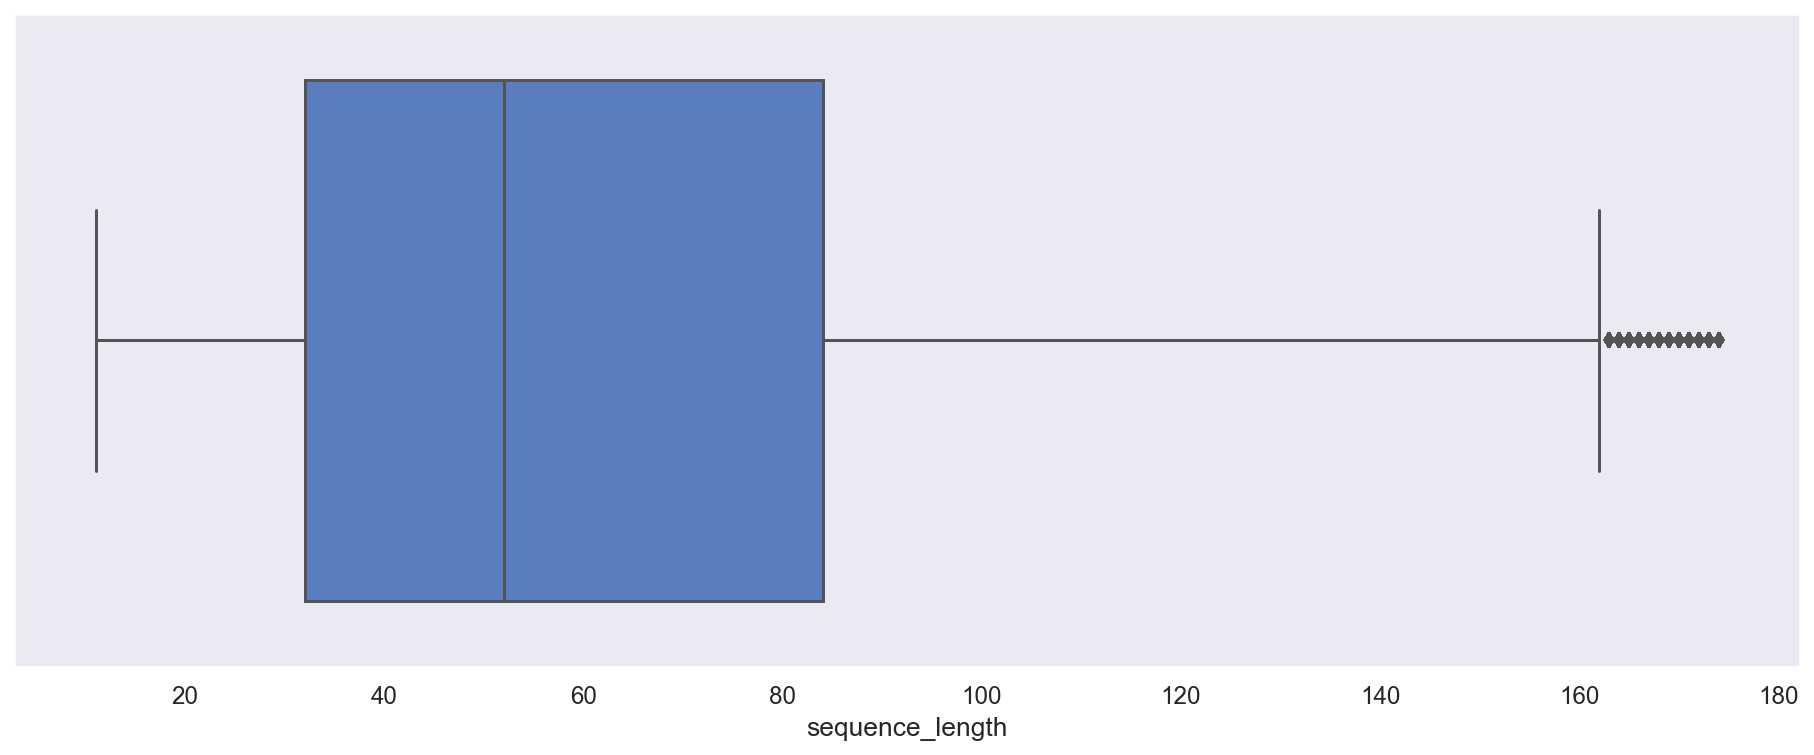

In [33]:
sns.boxplot(df[(df.sequence_length < 175) & (df.sequence_length > 10)].sequence_length)

In [34]:
MAX_SEQUENCE_LENGTH = 175
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [35]:
data[:10]

array([[    0,     0,     0, ...,    98,    58,   140],
       [    0,     0,     0, ...,    39,    23,  5709],
       [    0,     0,     0, ...,     5,     1, 13803],
       ...,
       [    0,     0,     0, ...,     6,    38,   911],
       [    0,     0,     0, ...,     3,  3324,    69],
       [    0,     0,     0, ...,    32,   164,   681]], dtype=int32)

In [36]:
data.shape

(567589, 175)

### One-Hot Encode Labels

Our labels are currently numbers 1, 2, 3, 4, 5, corresponding to the number of stars a reviewer gave a product.  

Downstream models will generally perform better with one-hot encoded vectors.

In [37]:
draft_score = df.score

In [38]:
# Re-index labels to start at 0 (to_categorical expects this)

draft_score = np.subtract(draft_score, 1)

In [39]:
np.unique(draft_score)

array([0, 1, 2, 3, 4], dtype=int64)

In [40]:
draft_score = to_categorical(draft_score)

In [41]:
draft_score

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## Split Data into Train and Test groups

In [42]:
VALIDATION_SPLIT = 0.2

labels = np.subtract(df.score, 1)  # start score values with 0 for to_categorical to work properly
labels = to_categorical(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (567589, 175)
Shape of label tensor: (567589, 5)


In [43]:
from sklearn.model_selection import train_test_split, KFold  # TODO KFold cross validation
from sklearn.utils import resample

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=VALIDATION_SPLIT, random_state=8)

In [44]:
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test:  {y_test.shape}')

X_train: (454071, 175)
X_test:  (113518, 175)
y_train: (454071, 5)
y_test:  (113518, 5)


## Load GloVe vectors to build embedding layer of CNN

The standard pre-trained GloVe Wikipedia 2014 + GigaWord 5 set contains 6B tokens, 400K vocab size, and optional word embedding dimensions of 50, 100, 200, and 300.

I'll choose the 100-dimension vectors for this model.

In [45]:
from os.path import expanduser

HOME_DIR = expanduser("~")
GLOVE_DIR = "data/glove.6B"

embeddings_index = {}

with open(os.path.join(HOME_DIR, GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [46]:
print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [47]:
EMBEDDING_DIM = 100

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## CNN Text Classifier

This CNN architecture is adapted from the simple CNN described in Richard Liao's blog article:

> (https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/)

which follows the example from:

> (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

I will modify the output layer to match the label shape for this problem - 5 instead of 2.

I have modified the architecture described in that article to make the number of filters in each convolutional layer significantly smaller, to see the effect on initial model performance.

Note also that the `Conv1D` layer from Keras may require non-default `data_format` parameter to be set to `'channels_first'`.  The default value is `'channels_last'`, but this throws an exception on my Macbook Pro (quad-core i7)

In [48]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model

In [49]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [50]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

l_cov1= Conv1D(8, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5, data_format='channels_first')(l_cov1)
l_cov2 = Conv1D(8, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5, data_format='channels_first')(l_cov2)
l_cov3 = Conv1D(40, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35, data_format='channels_first')(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(16, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [51]:
model = Model(sequence_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 175)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 175, 100)          12297900  
_________________________________________________________________
conv1d (Conv1D)              (None, 171, 8)            4008      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 171, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 167, 8)            48        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 167, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 163, 40)           240   

In [52]:
cnn_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=8, batch_size=64)

Train on 454071 samples, validate on 113518 samples
Epoch 1/8
454071/454071 [==============================] - 507s 1ms/sample - loss: 0.8925 - acc: 0.6721 - val_loss: 0.8340 - val_acc: 0.6921
Epoch 2/8
454071/454071 [==============================] - 756s 2ms/sample - loss: 0.8130 - acc: 0.6930 - val_loss: 0.8226 - val_acc: 0.6933
Epoch 3/8
454071/454071 [==============================] - 774s 2ms/sample - loss: 0.7869 - acc: 0.6996 - val_loss: 0.7952 - val_acc: 0.6999
Epoch 4/8
454071/454071 [==============================] - 775s 2ms/sample - loss: 0.7692 - acc: 0.7055 - val_loss: 0.7884 - val_acc: 0.7030
Epoch 5/8
454071/454071 [==============================] - 775s 2ms/sample - loss: 0.7545 - acc: 0.7103 - val_loss: 0.8027 - val_acc: 0.6990
Epoch 6/8
454071/454071 [==============================] - 779s 2ms/sample - loss: 0.7423 - acc: 0.7160 - val_loss: 0.8586 - val_acc: 0.6954
Epoch 7/8
454071/454071 [==============================] - 777s 2ms/sample - loss: 0.7308 - acc: 0.720

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


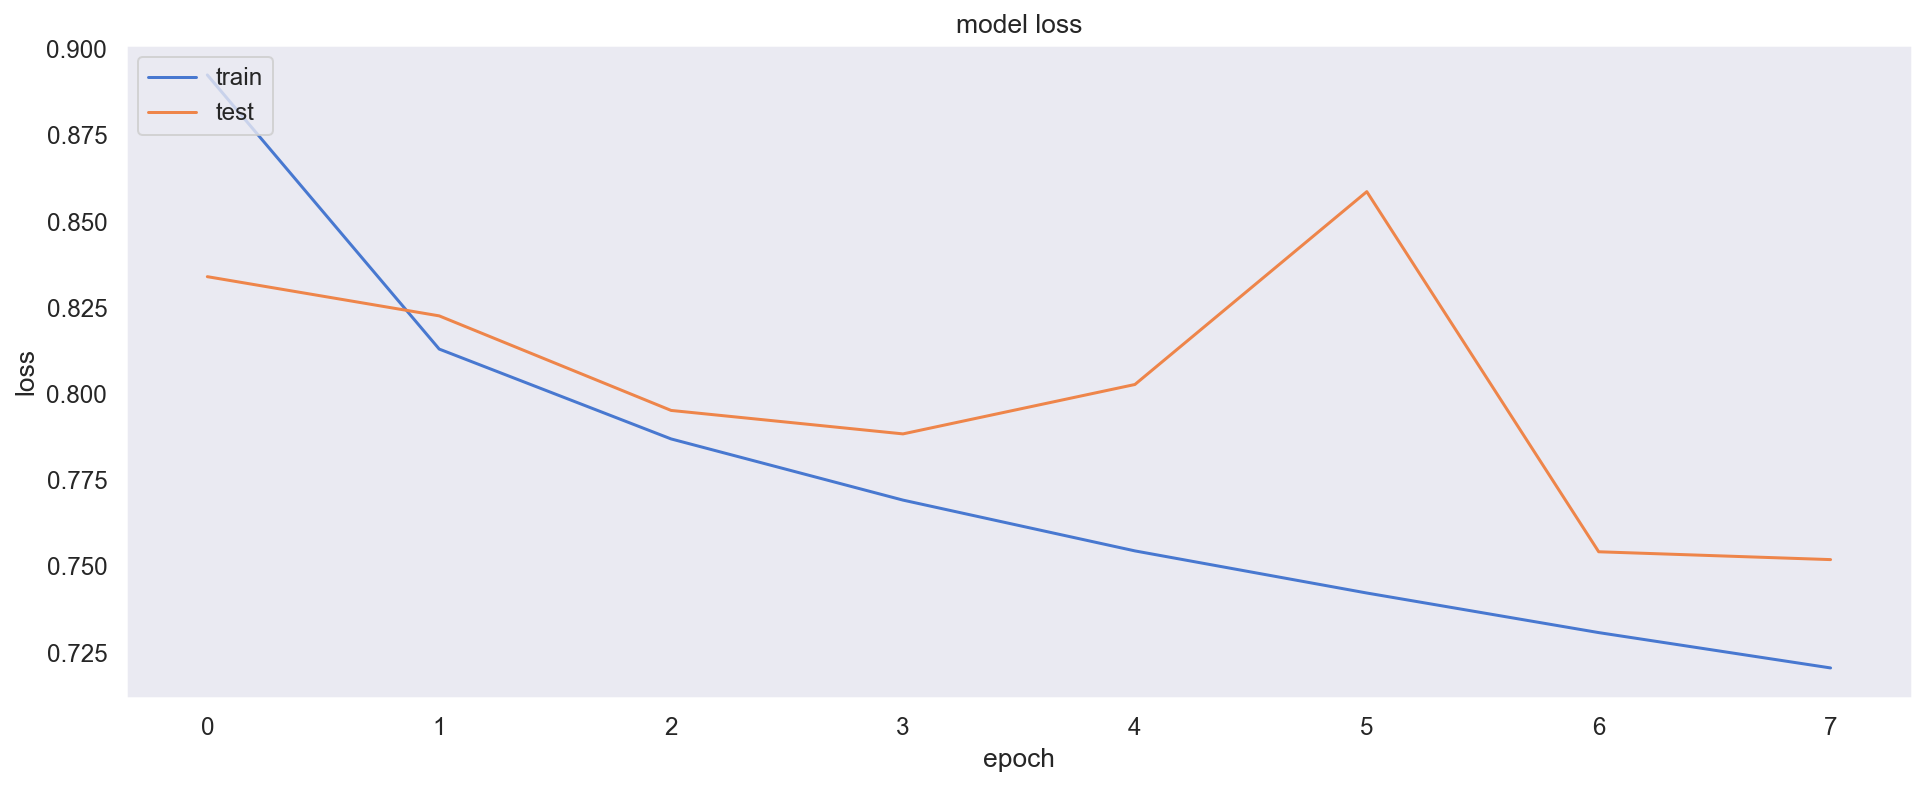

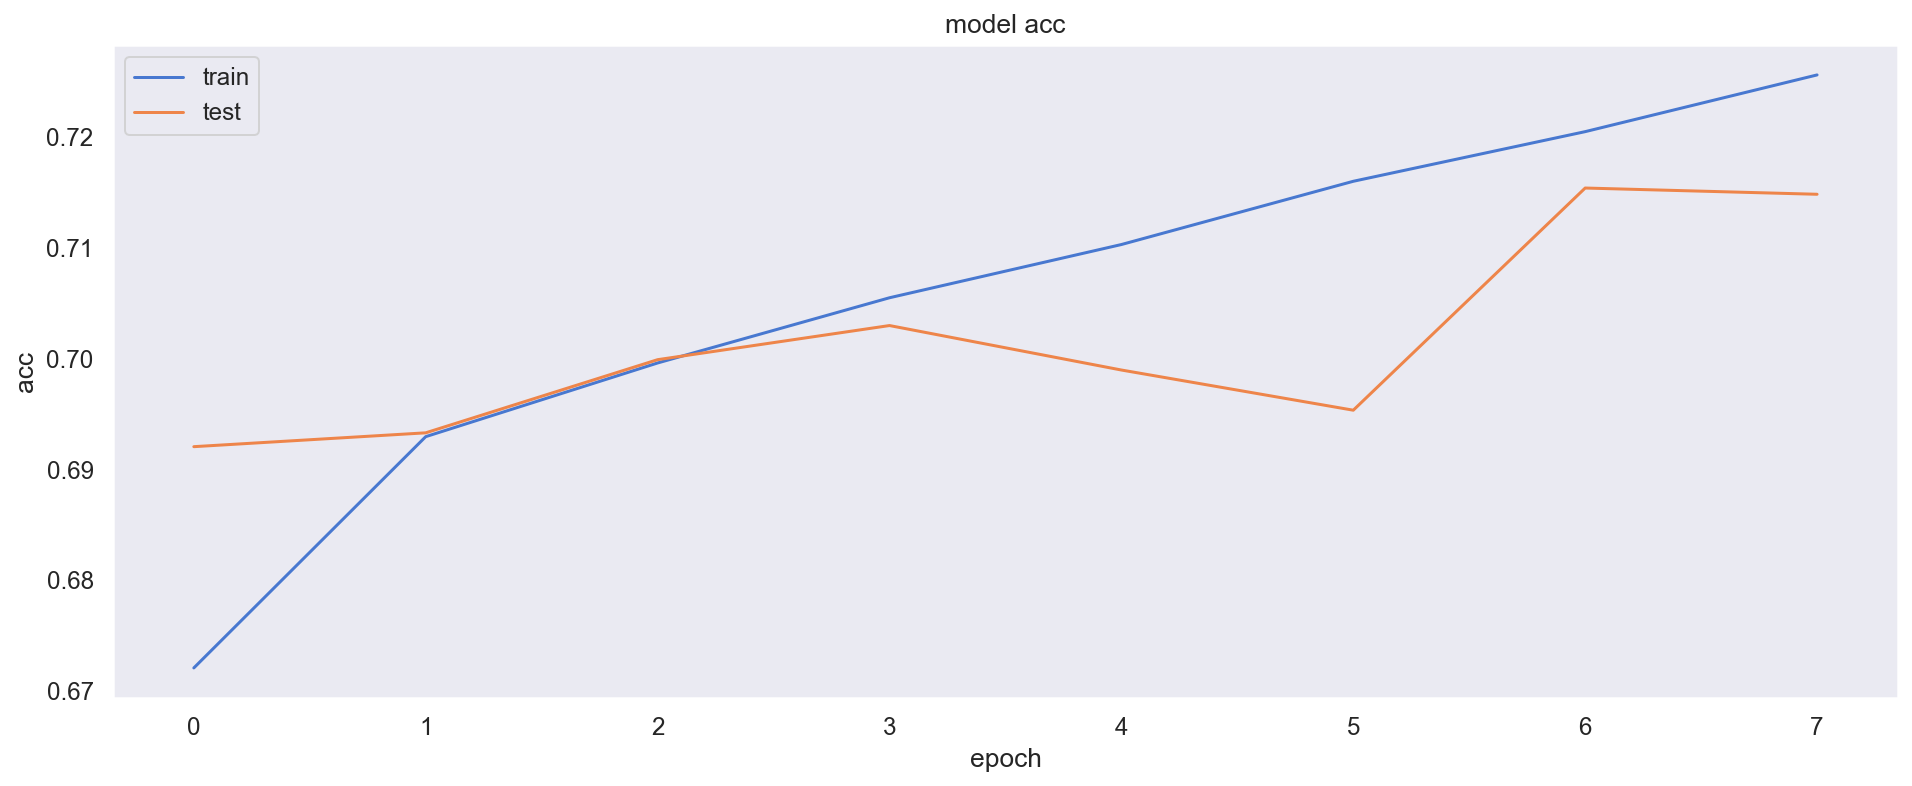

In [53]:
print(cnn_history.history.keys())
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
model.save_weights("tf_amz_food_model_CNN.h5")

## TFIDF Vectors

In [ ]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

In [ ]:
snow = SnowballStemmer('english')
stops = stopwords.words('english')

# Tokenize, drop stopwords, stem

def stem_tokenize_sents(sents):
    """
    stems and tokenize list of strings
    drops stop words. returns a tuple 
    of stemmed sents and tokenized stemmed 
    sents
    """
    stemmed_sents = []
    stemmed_tokens = []
    for i, sent in enumerate(sents):
        raw_tokens = sent.split()
        local_tokens = []
        for token in raw_tokens:
            if token not in stops:
                local_tokens.append(snow.stem(token))
        stemmed_tokens.append(local_tokens)
        stemmed_sents.append(' '.join(raw_tokens))
    return stemmed_sents, stemmed_tokens

In [ ]:
# get cleaned sentences as strings and as lilst of tokens
# clean_sents, clean_tokenized_sents = stem_tokenize_sents(sents)

In [ ]:
tf_idf = TfidfVectorizer(binary=True, max_features=6000, min_df=7, max_df=0.8, ngram_range=(1, 3))
tf_data = tf_idf.fit_transform(df['review_clean']).toarray()

In [ ]:
tf_idf.vocabulary_['highly recommend']

In [ ]:
tf_data[:3]

In [ ]:
len(tf_idf.vocabulary_)

In [ ]:
# each vector is size of vocabulary
i = 0
while i <= 2:
    print(len(tf_data[i]))
    i+=1

In [ ]:
# number of records
len(tf_data)

## Split Data

Split data into train and test groups and oversample minority classes using SMOTE

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample

In [ ]:
# look at review length stats by score
df.groupby('score').describe()['review_length']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_data, df.score, test_size=0.2, random_state=8)

In [ ]:
sns.distplot(y_train)

In [ ]:
# Use SMOTE for oversampling

oversample = SMOTE()

X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
sns.distplot(y_train)

In [ ]:
X_train[1:20]

In [ ]:
print(len(y_train))
print(len(X_train))

## Classifiers

### Random Forest

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=250, random_state=0)
text_classifier.fit(X_train, y_train)

In [ ]:
# Make predictions on test data
predictions = text_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cf_matrix)
print('\n\n')

print('Classification Report')
print(classification_report(y_test, predictions))
print('\n\n')

print('Accuracy')
print(accuracy_score(y_test, predictions))

### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
text_classifier = GaussianNB()
text_classifier.fit(X_train, y_train)

In [ ]:
predictions = text_classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

In [ ]:
predictions = logreg.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

## Neural Network Approaches

### Neural Network, basic multilayer perceptron with Dropout, discrete output

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.initializers import he_normal, RandomNormal

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=len(tf_idf.vocabulary_)))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

#### One-hot encode target for NN

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [ ]:
lb = LabelEncoder()
y = lb.fit_transform(y_train)
y = to_categorical(y)

In [ ]:
y[:3]

In [ ]:
y.shape

In [ ]:
y_0 = lb.fit_transform(y_test)
y_0 = to_categorical(y_0)

In [ ]:
# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y, validation_data=(X_test, y_0), epochs=20, batch_size=16)

In [ ]:
model.save_weights("tf_amz_food_model_NN.h5")

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Neural Network, basic multilayer perceptron with Dropout, continuous output

In [ ]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(0.001)
    
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(tf_idf.vocabulary_)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

In [ ]:
y_train[:8]

In [ ]:
y_train_cont = np.true_divide(y_train, 5).to_numpy()
y_train_cont[:8]

In [ ]:
y_1 = np.true_divide(y_test, 5).to_numpy()
y_1[:8]

In [ ]:
history = model.fit(X_train, y_train_cont, validation_data=(X_test, y_1), epochs=3, batch_size=16)

In [ ]:
act = y_1[7:20]

In [ ]:
res = model.predict(X_test)

In [ ]:
sns.scatterplot(y_1.flatten(), res.flatten())
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Sentiment Analysis

### Crude Sentiment Analysis

In [ ]:
positive_words = [
    'good', 'great', 'love', 'loved', 'fantastic', 
    'delicious', 'excellent', 'satisfied', 'well', 'nice', 
    'perfect', 'perfectly', 'thanks', 'thank', 'tasty', 'fun'
]

negative_words = [
    'bad', 'horrible', 'disappointed', 'damaged', 
    'terrible', 'hate', 'garbage', 'worthless',
    'cheap', 'wrong', 'frustrating', 'frustrated',
    'disgusting', 'gross', 'horrible', 'nasty',
    'spoiled', 'stale', 'watery'
]

def sum_count_in_list(words, word_list):
    count = 0
    for word in words:
        if word in word_list:
            count += 1
    return count

In [ ]:
df['pos_word_count'] = df['review_tokens'].apply(lambda x: sum_count_in_list(x, positive_words))
df['neg_word_count'] = df['review_tokens'].apply(lambda x: sum_count_in_list(x, negative_words))

In [ ]:
df.head(3)

In [ ]:
df_corr = df[['pos_word_count', 'neg_word_count', 'review_length', 'score']].corr()
df_corr

In [ ]:
sns.heatmap(df_corr, annot=True)